### 1. RAG系统搭建的基本流程 （ Basic Workflow for Building a RAG ）



## <img src="./assets/rag.png" style="margin-left: 0px" width=1024px>

搭建过程：

1. 文档加载，并按一定条件**切割**成片段
2. 将切割的文本片段灌入**检索引擎**
3. 封装**检索接口**
4. 构建**调用流程**：Query -> 检索 -> Prompt -> LLM -> 回复

#### 1.1 文档的加载与切割

In [1]:
from pdfminer.high_level import extract_pages
from pdfminer.layout import LTTextContainer

In [2]:
def extract_text_from_pdf(filename, page_numbers=None, min_line_length=1):
    '''从 PDF 文件中（按指定页码）提取文字'''
    paragraphs = []
    buffer = ''
    full_text = ''
    # 提取全部文本
    for i, page_layout in enumerate(extract_pages(filename)):
        # 如果指定了页码范围，跳过范围外的页
        if page_numbers is not None and i not in page_numbers:
            continue
        for element in page_layout:
            if isinstance(element, LTTextContainer):
                full_text += element.get_text() + '\n'
    # 这段代码的目标就是：还原“段落”结构，而不仅仅是一行一行的文本。
    lines = full_text.split('\n')
    for text in lines:
        if len(text) >= min_line_length:
            buffer += (' '+text) if not text.endswith('-') else text.strip('-')
        elif buffer:
            paragraphs.append(buffer)
            buffer = ''
    if buffer:
        paragraphs.append(buffer)
    return paragraphs

In [3]:
paragraphs = extract_text_from_pdf("llama2.pdf", min_line_length=10)

for para in paragraphs[:4]:
    print(para+"\n")

 Llama 2: Open Foundation and Fine-Tuned Chat Models

 Hugo Touvron∗ Louis Martin† Kevin Stone† Peter Albert Amjad Almahairi Yasmine Babaei Nikolay Bashlykov Soumya Batra Prajjwal Bhargava Shruti Bhosale Dan Bikel Lukas Blecher Cristian Canton Ferrer Moya Chen Guillem Cucurull David Esiobu Jude Fernandes Jeremy Fu Wenyin Fu Brian Fuller Cynthia Gao Vedanuj Goswami Naman Goyal Anthony Hartshorn Saghar Hosseini Rui Hou Hakan Inan Marcin Kardas Viktor Kerkez Madian Khabsa Isabel Kloumann Artem Korenev Punit Singh Koura Marie-Anne Lachaux Thibaut Lavril Jenya Lee Diana Liskovich Yinghai Lu Yuning Mao Xavier Martinet Todor Mihaylov Pushkar Mishra Igor Molybog Yixin Nie Andrew Poulton Jeremy Reizenstein Rashi Rungta Kalyan Saladi Alan Schelten Ruan Silva Eric Michael Smith Ranjan Subramanian Xiaoqing Ellen Tan Binh Tang Ross Taylor Adina Williams Jian Xiang Kuan Puxin Xu Zheng Yan Iliyan Zarov Yuchen Zhang Angela Fan Melanie Kambadur Sharan Narang Aurelien Rodriguez Robert Stojnic Sergey Edu

#### 1.2 LLM接口封装

In [14]:
from openai import OpenAI
import os

# 加载环境变量
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv(), verbose=True)  # 读取本地 .env 文件，里面定义了 OPENAI_API_KEY

client = OpenAI()

In [5]:
def get_completion(prompt, model="gpt-4o"):
    '''封装 openai 接口'''
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,  # 模型输出的随机性，0 表示随机性最小
    )
    return response.choices[0].message.content

#### 1.3 Prompt模版

In [6]:
def build_prompt(prompt_template, **kwargs):
    '''将 Prompt 模板赋值'''
    inputs = {}
    for k, v in kwargs.items():
        if isinstance(v, list) and all(isinstance(elem, str) for elem in v):
            val = '\n\n'.join(v)
        else:
            val = v
        inputs[k] = val
    return prompt_template.format(**inputs)

In [7]:
prompt_template = """
你是一个问答机器人。
你的任务是根据下述给定的已知信息回答用户问题。

已知信息:
{context} # 检索出来的原始文档

用户问：
{query} # 用户的提问

如果已知信息不包含用户问题的答案，或者已知信息不足以回答用户的问题，请直接回复"我无法回答您的问题"。
请不要输出已知信息中不包含的信息或答案。
请用中文回答用户问题。
"""

### 2 向量检索

#### 2.1 向量的定义

向量是一种有大小和方向的数学对象。它可以表示为从一个点到另一个点的有向线段。例如，二维空间中的向量可以表示为 $(x,y)$，表示从原点 $(0,0)$ 到点 $(x,y)$ 的有向线段。
<br />
<img src="./assets/vector.png" style="margin-left: 0px" width=800px>
<br />
以此类推，我可以用一组坐标 $(x_0, x_1, \ldots, x_{N-1})$ 表示一个 $N$ 维空间中的向量，$N$ 叫向量的维度。

##### 2.1.1 文本向量
1. 将文本转成一组 $N$ 维浮点数，即**文本向量**又叫 Embeddings
2. 向量之间可以计算距离，距离远近对应**语义相似度**大小

<br />
<img src="./assets/embeddings.png" style="margin-left: 0px" width=800px>
<br />

##### 2.1.2 文本向量如何计算

1. 构建相关（正例）与不相关（负例）的句子对样本
2. 训练双塔式模型，让正例间的距离小，负例间的距离大

例如：

<img src="./assets/sbert.png" style="margin-left: 0px" width=500px>

#### 2.2 向量间的相似度计算

In [8]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [9]:
def cos_sim(a, b):
    '''余弦距离 -- 越大越相似'''
    return dot(a, b)/(norm(a)*norm(b))


def l2(a, b):
    '''欧氏距离 -- 越小越相似'''
    x = np.asarray(a)-np.asarray(b)
    return norm(x)

In [19]:
def get_embeddings(texts, model="text-embedding-ada-002", dimensions=None):
    '''封装 OpenAI 的 Embedding 模型接口'''
    if model == "text-embedding-ada-002":
        dimensions = None
    if dimensions:
        data = client.embeddings.create(
            input=texts, model=model, dimensions=dimensions).data
    else:
        data = client.embeddings.create(input=texts, model=model).data
    return [x.embedding for x in data]

In [12]:
test_query = ["测试文本"]
vec = get_embeddings(test_query)[0]
print(f"Total dimension: {len(vec)}")
print(f"First 10 elements: {vec[:10]}")

Total dimension: 1536
First 10 elements: [-0.007280503865331411, -0.006169671658426523, -0.010576579719781876, 0.001448634546250105, -0.010707695037126541, 0.02919485792517662, -0.019725468009710312, 0.0053902678191661835, -0.016957491636276245, -0.01203340943902731]


In [13]:
query = "国际争端"

# query = "global conflicts"

documents = [
    "联合国就苏丹达尔富尔地区大规模暴力事件发出警告",
    "土耳其、芬兰、瑞典与北约代表将继续就瑞典“入约”问题进行谈判",
    "日本岐阜市陆上自卫队射击场内发生枪击事件 3人受伤",
    "国家游泳中心（水立方）：恢复游泳、嬉水乐园等水上项目运营",
    "我国首次在空间站开展舱外辐射生物学暴露实验",
]

query_vec = get_embeddings([query])[0]
doc_vecs = get_embeddings(documents)

print("Query与自己的余弦距离: {:.2f}".format(cos_sim(query_vec, query_vec)))
print("Query与Documents的余弦距离:")
for vec in doc_vecs:
    print(cos_sim(query_vec, vec))

print()

print("Query与自己的欧氏距离: {:.2f}".format(l2(query_vec, query_vec)))
print("Query与Documents的欧氏距离:")
for vec in doc_vecs:
    print(l2(query_vec, vec))

Query与自己的余弦距离: 1.00
Query与Documents的余弦距离:
0.8218706620454886
0.8293604312024739
0.7977419321704446
0.7668734038746805
0.7930347492306307

Query与自己的欧氏距离: 0.00
Query与Documents的欧氏距离:
0.5968741071718394
0.5841910061583281
0.636015828793664
0.6828273510133333
0.6433743189941651


#### 2.3 向量数据库

In [14]:
# 为了演示方便，我们只取两页（第一章）
paragraphs = extract_text_from_pdf(
    "llama2.pdf",
    page_numbers=[2, 3],
    min_line_length=10
)

In [15]:
import chromadb
from chromadb.config import Settings

class MyVectorDBConnector:
    def __init__(self, collection_name, embedding_fn):
        chroma_client = chromadb.Client(Settings(allow_reset=True))

        # 为了演示，实际不需要每次 reset()
        chroma_client.reset()

        # 创建一个 collection
        self.collection = chroma_client.get_or_create_collection(name=collection_name)
        self.embedding_fn = embedding_fn

    def add_documents(self, documents):
        '''向 collection 中添加文档与向量'''
        self.collection.add(
            embeddings=self.embedding_fn(documents),  # 每个文档的向量
            documents=documents,  # 文档的原文
            ids=[f"id{i}" for i in range(len(documents))]  # 每个文档的 id
        )

    def search(self, query, top_n):
        '''检索向量数据库'''
        results = self.collection.query(
            query_embeddings=self.embedding_fn([query]),
            n_results=top_n
        )
        return results

In [16]:
# 创建一个向量数据库对象
vector_db = MyVectorDBConnector("demo", get_embeddings)
# 向向量数据库中添加文档
vector_db.add_documents(paragraphs)

user_query = "Llama 2有多少参数"
# user_query = "Does Llama 2 have a conversational variant"
results = vector_db.search(user_query, 2)

for para in results['documents'][0]:
    print(para+"\n")

 1. Llama 2, an updated version of Llama 1, trained on a new mix of publicly available data. We also increased the size of the pretraining corpus by 40%, doubled the context length of the model, and adopted grouped-query attention (Ainslie et al., 2023). We are releasing variants of Llama 2 with 7B, 13B, and 70B parameters. We have also trained 34B variants, which we report on in this paper but are not releasing.§

 In this work, we develop and release Llama 2, a family of pretrained and ﬁne-tuned LLMs, Llama 2 and Llama 2-Chat, at scales up to 70B parameters. On the series of helpfulness and safety benchmarks we tested, Llama 2-Chat models generally perform better than existing open-source models. They also appear to be on par with some of the closed-source models, at least on the human evaluations we performed (see Figures 1 and 3). We have taken measures to increase the safety of these models, using safety-speciﬁc data annotation and tuning, as well as conducting red-teaming and emp

<b>注意：</b><ul>
    <li>向量数据库的意义是快速的检索；</li>
    <li>向量数据库本身不生成向量，向量是由 Embedding 模型产生的；</li>
    <li>向量数据库与传统的关系型数据库是互补的，不是替代关系，在实际应用中根据实际需求经常同时使用。</li>
</ul>
</div>

##### 3.3.1 向量数据库服务

Server 端
```sh
chroma run --path /db_path
```
Client 端
```python
import chromadb
chroma_client = chromadb.HttpClient(host='localhost', port=8000)
```

#### 2.4 基于向量检索的RAG

In [17]:
class RAG_Bot:
    def __init__(self, vector_db, llm_api, n_results=2):
        self.vector_db = vector_db
        self.llm_api = llm_api
        self.n_results = n_results

    def chat(self, user_query):
        # 1. 检索
        search_results = self.vector_db.search(user_query, self.n_results)

        # 2. 构建 Prompt
        prompt = build_prompt(
            prompt_template, context=search_results['documents'][0], query=user_query)

        # 3. 调用 LLM
        response = self.llm_api(prompt)
        return response

In [18]:
# 创建一个RAG机器人
bot = RAG_Bot(
    vector_db,
    llm_api=get_completion
)

user_query = "llama 2有多少参数?"

response = bot.chat(user_query)

print(response)

Llama 2 有 7B、13B 和 70B 参数的变体。


### 3 RAG实战的进阶知识

#### 3.1 文本分割的粒度
##### 缺点：
1. 粒度太大可能导致检索不精准，粒度太小可能导致信息不全面
2. 问题的答案可能跨越两个片段
##### 改进：
按一定的粒度，部分重叠式切割文本，使上下文更完整

In [19]:
# 创建一个向量数据库对象
vector_db = MyVectorDBConnector("demo_text_split", get_embeddings)
# 向向量数据库中添加文档
vector_db.add_documents(paragraphs)

# 创建一个RAG机器人
bot = RAG_Bot(
    vector_db,
    llm_api=get_completion
)

In [20]:
# user_query = "llama 2有商用许可协议吗"
user_query="llama 2 chat有多少参数"
search_results = vector_db.search(user_query, 2)

for doc in search_results['documents'][0]:
    print(doc+"\n")

print("====回复====")
bot.chat(user_query)

 In this work, we develop and release Llama 2, a family of pretrained and ﬁne-tuned LLMs, Llama 2 and Llama 2-Chat, at scales up to 70B parameters. On the series of helpfulness and safety benchmarks we tested, Llama 2-Chat models generally perform better than existing open-source models. They also appear to be on par with some of the closed-source models, at least on the human evaluations we performed (see Figures 1 and 3). We have taken measures to increase the safety of these models, using safety-speciﬁc data annotation and tuning, as well as conducting red-teaming and employing iterative evaluations. Additionally, this paper contributes a thorough description of our ﬁne-tuning methodology and approach to improving LLM safety. We hope that this openness will enable the community to reproduce ﬁne-tuned LLMs and continue to improve the safety of those models, paving the way for more responsible development of LLMs. We also share novel observations we made during the development of Llam

'Llama 2-Chat的参数规模可以达到70B。'

In [21]:
for p in paragraphs:
    print(p+"\n")

 Figure 1: Helpfulness human evaluation results for Llama 2-Chat compared to other open-source and closed-source models. Human raters compared model generations on ~4k prompts consisting of both single and multi-turn prompts. The 95% conﬁdence intervals for this evaluation are between 1% and 2%. More details in Section 3.4.2. While reviewing these results, it is important to note that human evaluations can be noisy due to limitations of the prompt set, subjectivity of the review guidelines, subjectivity of individual raters, and the inherent diﬃculty of comparing generations.

 Figure 2: Win-rate % for helpfulness andsafety between commercial-licensed baselines and Llama 2-Chat, according to GPT 4. To complement the human evaluation, we used a more capable model, not subject to our own guidance. Green area indicates our model is better according to GPT-4. To remove ties, we used win/(win + loss). The orders in which the model responses are presented to GPT-4 are randomly swapped to all

##### 部分重叠式切割文本
处理英文

In [22]:
from nltk.tokenize import sent_tokenize
import json

def split_text(paragraphs, chunk_size=300, overlap_size=100):
    '''按指定 chunk_size 和 overlap_size 交叠割文本'''
    sentences = [s.strip() for p in paragraphs for s in sent_tokenize(p)]
    chunks = []
    i = 0
    while i < len(sentences):
        chunk = sentences[i]
        overlap = ''
        prev_len = 0
        prev = i - 1
        # 向前计算重叠部分
        while prev >= 0 and len(sentences[prev])+len(overlap) <= overlap_size:
            overlap = sentences[prev] + ' ' + overlap
            prev -= 1
        chunk = overlap+chunk
        next = i + 1
        # 向后计算当前chunk
        while next < len(sentences) and len(sentences[next])+len(chunk) <= chunk_size:
            chunk = chunk + ' ' + sentences[next]
            next += 1
        chunks.append(chunk)
        i = next
    return chunks

处理中文

In [23]:
from chinese_utils import sent_tokenize

def split_chinese_text(paragraphs, chunk_size=300, overlap_size=100):
    sentences = [s.strip() for p in paragraphs for s in sent_tokenize(p)]
    chunks = []
    i = 0
    while i < len(sentences):
        chunk = sentences[i]
        overlap = ''
        prev = i - 1
        while prev >= 0 and len(overlap) + len(sentences[prev]) <= overlap_size:
            overlap = sentences[prev] + ' ' + overlap
            prev -= 1
        chunk = overlap + chunk
        next = i + 1
        while next < len(sentences) and len(chunk) + len(sentences[next]) <= chunk_size:
            chunk += ' ' + sentences[next]
            next += 1
        chunks.append(chunk)
        i = next
    return chunks

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\李世勋\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
chunks = split_text(paragraphs, 300, 100)

In [26]:
# 创建一个向量数据库对象
vector_db = MyVectorDBConnector("demo_text_split", get_embeddings)
# 向向量数据库中添加文档
vector_db.add_documents(chunks)
# 创建一个RAG机器人
bot = RAG_Bot(
    vector_db,
    llm_api=get_completion
)

In [31]:
# user_query = "llama 2有商用许可协议吗"
user_query="llama 2 chat有多少参数"

search_results = vector_db.search(user_query, 2)
for doc in search_results['documents'][0]:
    print(doc+"\n")

response = bot.chat(user_query)
print("====回复====")
print(response)

2. Llama 2-Chat, a ﬁne-tuned version of Llama 2 that is optimized for dialogue use cases. We release variants of this model with 7B, 13B, and 70B parameters as well.

In this work, we develop and release Llama 2, a family of pretrained and ﬁne-tuned LLMs, Llama 2 and Llama 2-Chat, at scales up to 70B parameters. On the series of helpfulness and safety benchmarks we tested, Llama 2-Chat models generally perform better than existing open-source models. They also appear to be on par with some of the closed-source models, at least on the human evaluations we performed (see Figures 1 and 3). We have taken measures to increase the safety of these models, using safety-speciﬁc data annotation and tuning, as well as conducting red-teaming and employing iterative evaluations. Additionally, this paper contributes a thorough description of our ﬁne-tuning methodology and approach to improving LLM safety. We hope that this openness will enable the community to reproduce ﬁne-tuned LLMs and continue t

#### 3.2 检索后排序
有时，最合适的答案不一定排在检索的最前面

In [30]:
user_query = "how safe is llama 2"
search_results = vector_db.search(user_query, 5)

for doc in search_results['documents'][0]:
    print(doc+"\n")

response = bot.chat(user_query)
print("====回复====")
print(response)

In this work, we develop and release Llama 2, a family of pretrained and ﬁne-tuned LLMs, Llama 2 and Llama 2-Chat, at scales up to 70B parameters. On the series of helpfulness and safety benchmarks we tested, Llama 2-Chat models generally perform better than existing open-source models. They also appear to be on par with some of the closed-source models, at least on the human evaluations we performed (see Figures 1 and 3). We have taken measures to increase the safety of these models, using safety-speciﬁc data annotation and tuning, as well as conducting red-teaming and employing iterative evaluations. Additionally, this paper contributes a thorough description of our ﬁne-tuning methodology and approach to improving LLM safety. We hope that this openness will enable the community to reproduce ﬁne-tuned LLMs and continue to improve the safety of those models, paving the way for more responsible development of LLMs. We also share novel observations we made during the development of Llama

**方案**:

1. 检索时招回一部分文本
2. 通过一个排序模型对 query 和 document 重新打分排序

<img src="./assets/sbert-rerank.png" style="margin-left: 0px" width=600px>

In [33]:
from sentence_transformers import CrossEncoder

# model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512) # 英文，模型较小
model = CrossEncoder('BAAI/bge-reranker-large', max_length=512) # 多语言，国产，模型较大

D:\Anaconda3\envs\LLM\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\李世勋\.cache\huggingface\hub\models--BAAI--bge-reranker-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [35]:
user_query = "how safe is llama 2"
# user_query = "llama 2安全性如何"
scores = model.predict([(user_query, doc)
                       for doc in search_results['documents'][0]])
# 按得分排序
sorted_list = sorted(
    zip(scores, search_results['documents'][0]), key=lambda x: x[0], reverse=True)
for score, doc in sorted_list:
    print(f"{score}\t{doc}\n")

0.9527947306632996	In this work, we develop and release Llama 2, a family of pretrained and ﬁne-tuned LLMs, Llama 2 and Llama 2-Chat, at scales up to 70B parameters. On the series of helpfulness and safety benchmarks we tested, Llama 2-Chat models generally perform better than existing open-source models. They also appear to be on par with some of the closed-source models, at least on the human evaluations we performed (see Figures 1 and 3). We have taken measures to increase the safety of these models, using safety-speciﬁc data annotation and tuning, as well as conducting red-teaming and employing iterative evaluations. Additionally, this paper contributes a thorough description of our ﬁne-tuning methodology and approach to improving LLM safety. We hope that this openness will enable the community to reproduce ﬁne-tuned LLMs and continue to improve the safety of those models, paving the way for more responsible development of LLMs. We also share novel observations we made during the d

### 4 处理PDF文档里的表格



<img src="./assets/table_rag.png" style="margin-left: 0px" width="800px">

#### 4.1.将每页PDF转换成图片

In [1]:
import os
import fitz
from PIL import Image

def pdf2images(pdf_file):
    '''将 PDF 每页转成一个 PNG 图像'''
    # 保存路径为原 PDF 文件名（不含扩展名）
    output_directory_path, _ = os.path.splitext(pdf_file)

    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)

    # 加载 PDF 文件
    pdf_document = fitz.open(pdf_file)

    # 每页转一张图
    for page_number in range(pdf_document.page_count):
        # 取一页
        page = pdf_document[page_number]

        # 转图像
        pix = page.get_pixmap()

        # 从位图创建 PNG 对象
        image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

        # 保存 PNG 文件
        image.save(f"./{output_directory_path}/page_{page_number + 1}.png")

    # 关闭 PDF 文件
    pdf_document.close()

In [2]:
from PIL import Image
import os
import matplotlib.pyplot as plt

def show_images(dir_path):
    '''显示目录下的 PNG 图像'''
    for file in os.listdir(dir_path):
        if file.endswith('.png'):
            # 打开图像
            img = Image.open(os.path.join(dir_path, file))

            # 显示图像
            plt.imshow(img)
            plt.axis('off')  # 不显示坐标轴
            plt.show()

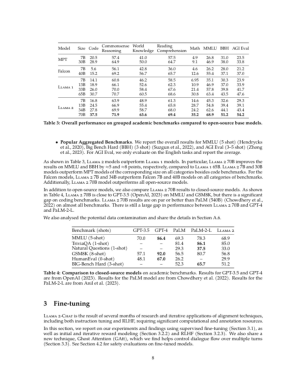

In [3]:
pdf2images("llama2_page8.pdf")
show_images("llama2_page8")

#### 4.2. 识别文档中表格

In [4]:
class MaxResize(object):
    '''缩放图像'''
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize(
            (int(round(scale * width)), int(round(scale * height)))
        )

        return resized_image

In [5]:
import torchvision.transforms as transforms

# 图像预处理
detection_transform = transforms.Compose(
    [
        MaxResize(800),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

In [8]:
from transformers import AutoModelForObjectDetection

# 加载 TableTransformer 模型
model = AutoModelForObjectDetection.from_pretrained(
    "microsoft/table-transformer-detection"
)

D:\Anaconda3\envs\LLM\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\李世勋\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
D:\Anaconda3\envs\LLM\lib\site-packages\torch\nn\modules\module.py:2409: UserWarning: for conv1.weight: copying from a non-meta

In [10]:
import torch

# 识别后的坐标换算与后处理

def box_cxcywh_to_xyxy(x):
    '''坐标转换'''
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    '''区域缩放'''
    width, height = size
    boxes = box_cxcywh_to_xyxy(out_bbox)
    boxes = boxes * torch.tensor(
        [width, height, width, height], dtype=torch.float32
    )
    return boxes


def outputs_to_objects(outputs, img_size, id2label):
    '''从模型输出中取定位框坐标'''
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs["pred_boxes"].detach().cpu()[0]
    pred_bboxes = [
        elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)
    ]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == "no object":
            objects.append(
                {
                    "label": class_label,
                    "score": float(score),
                    "bbox": [float(elem) for elem in bbox],
                }
            )

    return objects

In [11]:
# 识别表格，并将表格部分单独存为图像文件

def detect_and_crop_save_table(file_path):
    # 加载图像（PDF页）
    image = Image.open(file_path)

    filename, _ = os.path.splitext(os.path.basename(file_path))

    # 输出路径
    cropped_table_directory = os.path.join(os.path.dirname(file_path), "table_images")

    if not os.path.exists(cropped_table_directory):
        os.makedirs(cropped_table_directory)

    # 预处理
    pixel_values = detection_transform(image).unsqueeze(0)

    # 识别表格
    with torch.no_grad():
        outputs = model(pixel_values)

    # 后处理，得到表格子区域
    id2label = model.config.id2label
    id2label[len(model.config.id2label)] = "no object"
    detected_tables = outputs_to_objects(outputs, image.size, id2label)

    print(f"number of tables detected {len(detected_tables)}")

    for idx in range(len(detected_tables)):
        # 将识别从的表格区域单独存为图像
        cropped_table = image.crop(detected_tables[idx]["bbox"])
        cropped_table.save(os.path.join(cropped_table_directory,f"{filename}_{idx}.png"))

number of tables detected 2


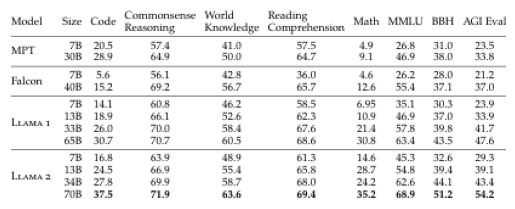

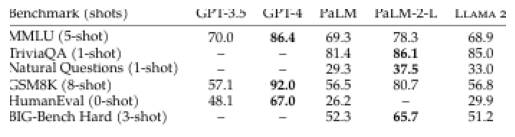

In [12]:
detect_and_crop_save_table("llama2_page8/page_1.png")
show_images("llama2_page8/table_images")

#### 4.3 基于GPT-4 Vision API做表格问答

In [15]:
import base64
from openai import OpenAI

client = OpenAI()

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

def image_qa(query, image_path):
    base64_image = encode_image(image_path)
    response = client.chat.completions.create(
        model="gpt-4o",
        temperature=0,
        seed=42,
        messages=[{
            "role": "user",
              "content": [
                  {"type": "text", "text": query},
                  {
                      "type": "image_url",
                      "image_url": {
                          "url": f"data:image/jpeg;base64,{base64_image}",
                      },
                  },
              ],
        }],
    )

    return response.choices[0].message.content

In [16]:
response = image_qa("哪个模型在AGI Eval数据集上表现最好。得分多少","llama2_page8/table_images/page_1_0.png")
print(response)

在AGI Eval数据集上表现最好的模型是LLaMA 2 70B，得分为54.2。


#### 4.4 用 GPT-4 Vision 生成表格（图像）描述，并向量化用于检索

In [17]:
import chromadb
from chromadb.config import Settings

class NewVectorDBConnector:
    def __init__(self, collection_name, embedding_fn):
        chroma_client = chromadb.Client(Settings(allow_reset=True))

        # 为了演示，实际不需要每次 reset()
        chroma_client.reset()

        # 创建一个 collection
        self.collection = chroma_client.get_or_create_collection(
            name=collection_name)
        self.embedding_fn = embedding_fn

    def add_documents(self, documents):
        '''向 collection 中添加文档与向量'''
        self.collection.add(
            embeddings=self.embedding_fn(documents),  # 每个文档的向量
            documents=documents,  # 文档的原文
            ids=[f"id{i}" for i in range(len(documents))]  # 每个文档的 id
        )

    def add_images(self, image_paths):
        '''向 collection 中添加图像'''
        documents = [
            image_qa("请简要描述图片中的信息",image)
            for image in image_paths
        ]
        self.collection.add(
            embeddings=self.embedding_fn(documents),  # 每个文档的向量
            documents=documents,  # 文档的原文
            ids=[f"id{i}" for i in range(len(documents))],  # 每个文档的 id
            metadatas=[{"image": image} for image in image_paths] # 用 metadata 标记源图像路径
        )

    def search(self, query, top_n):
        '''检索向量数据库'''
        results = self.collection.query(
            query_embeddings=self.embedding_fn([query]),
            n_results=top_n
        )
        return results

In [20]:
images = []
dir_path = "llama2_page8/table_images"
for file in os.listdir(dir_path):
    if file.endswith('.png'):
        # 打开图像
        images.append(os.path.join(dir_path, file))

new_db_connector = NewVectorDBConnector("table_demo",get_embeddings)
new_db_connector.add_images(images)

In [21]:
query  = "哪个模型在AGI Eval数据集上表现最好。得分多少"

results = new_db_connector.search(query, 1)
metadata = results["metadatas"][0]
print("====检索结果====")
print(metadata)
print("====回复====")
response = image_qa(query,metadata[0]["image"])
print(response)

====检索结果====
[{'image': 'llama2_page8/table_images\\page_1_0.png'}]
====回复====
在AGI Eval数据集上表现最好的模型是LLaMA 2 70B，得分为54.2。
